In [ ]:

# !pip install "git+https://github.com/time-series-foundation-models/lag-llama.git"
# !pip install pandas numpy torch matplotlib huggingface_hub

# source venv312-lagllama/bin/activate


In [12]:
import sys
from pathlib import Path

project_root = Path("/Users/jan/Documents/working papers/project 1")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)


Project root: /Users/jan/Documents/working papers/project 1


In [13]:
from pathlib import Path
import importlib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

print("Torch:", torch.__version__)
DEVICE = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print("Device:", DEVICE)

Torch: 2.8.0
Device: mps


In [23]:
# ---- Run this cell ONCE per kernel ----
import sys, types
from torch.serialization import add_safe_globals

# 1) Create dummy modules/classes so pickle can resolve the symbols
pkg = types.ModuleType("gluonts")
torchmod = types.ModuleType("gluonts.torch")
distmod  = types.ModuleType("gluonts.torch.distributions")
studmod  = types.ModuleType("gluonts.torch.distributions.studentT")
gaussmod = types.ModuleType("gluonts.torch.distributions.gaussian")
nbmod    = types.ModuleType("gluonts.torch.distributions.neg_binomial")

class StudentTOutput: pass
class GaussianOutput: pass
class NegativeBinomialOutput: pass

studmod.StudentTOutput = StudentTOutput
gaussmod.GaussianOutput = GaussianOutput
nbmod.NegativeBinomialOutput = NegativeBinomialOutput

sys.modules.update({
    "gluonts": pkg,
    "gluonts.torch": torchmod,
    "gluonts.torch.distributions": distmod,
    "gluonts.torch.distributions.studentT": studmod,
    "gluonts.torch.distributions.gaussian": gaussmod,
    "gluonts.torch.distributions.neg_binomial": nbmod,
})

# 2) Allow-list these classes for PyTorch 2.6 safe unpickler
add_safe_globals([StudentTOutput, GaussianOutput, NegativeBinomialOutput])

import torch, importlib
print("Torch:", torch.__version__, "— safe globals installed.")

Torch: 2.8.0 — safe globals installed.


In [24]:
import lagllama_no_gluonts
importlib.reload(lagllama_no_gluonts)  # in case you edit the helper

from lagllama_no_gluonts import forecast_no_lightning

In [15]:
#config
DATA_PATH = str(project_root / "data" / "btc_1h_test.csv")

def load_series(path: Path, ts_col="timestamp", y_col="close", tz="UTC"):
    df = pd.read_csv(path)
    df[ts_col] = pd.to_datetime(df[ts_col], utc=True)
    if tz:
        df[ts_col] = df[ts_col].dt.tz_convert(tz).dt.tz_localize(None)
    s = df.set_index(ts_col)[y_col].astype("float32").sort_index()

    freq = pd.infer_freq(s.index)
    if freq is None:
        
        step = pd.to_timedelta(pd.Series(s.index[1:] - s.index[:-1]).median())
        s = s.asfreq(step)
        freq = s.index.freqstr or str(step)
    print(f"Series length={len(s)}, freq={freq}, range=({s.index[0]} - {s.index[-1]})")
    return s, freq

y, inferred_freq = load_series(DATA_PATH)

Series length=10000, freq=H, range=(2018-01-01 00:00:00 - 2019-02-21 15:00:00)


In [25]:
# Rolling 1-step-ahead forecast (teacher-forced) — SIMPLE VERSION
PREDICTION_LENGTH = 1
CONTEXT_LENGTH    = 512
FREQ              = inferred_freq or "1H"

assert len(y) > CONTEXT_LENGTH + 1, "Series too short for chosen CONTEXT_LENGTH."

pred_vals = []
pred_idx  = []

y_hist = y.iloc[:CONTEXT_LENGTH].copy()           # initial context
for t in range(CONTEXT_LENGTH, len(y)):
    # 1-step forecast from current history
    df = forecast_no_lightning(
        y=y_hist,
        prediction_length=1,
        context_length=CONTEXT_LENGTH,
        freq=FREQ,
        num_samples=200,
        rope_scale=1.5,
    )
    pred_vals.append(float(df["mean"].iloc[-1]))
    pred_idx.append(df.index[-1])

    # teacher forcing: append the TRUE next observed value
    y_hist = pd.concat([y_hist, y.iloc[t:t+1]])

# Result: len = len(y) - CONTEXT_LENGTH
pred_rolling = pd.Series(pred_vals, index=pd.DatetimeIndex(pred_idx, name="timestamp"), name="mean")
print(f"Produced {len(pred_rolling)} one-step forecasts.")

ModuleNotFoundError: No module named 'gluonts.torch.modules'; 'gluonts.torch' is not a package

In [ ]:
pred_df = forecast_no_lightning(
    y=y_train,
    prediction_length=PREDICTION_LENGTH,
    context_length=CONTEXT_LENGTH,
    freq=FREQ,
    num_samples=400,          # increase for smoother quantiles
    rope_scale=1.5,           # harmless knob; helps longer contexts
)
pred_df.head()

In [ ]:
# save predictions
OUT_PRED_CSV = project_root / "models" / "LagLlama_zeroshot_btc_preds.csv"
OUT_PRED_CSV.parent.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(OUT_PRED_CSV, index=False)
print(f"Saved predictions to: {OUT_PRED_CSV}   (rows={len(pred_df)})")

Saved predictions to: /Users/jan/Documents/working papers/project 1/models/LagLlama_zeroshot_btc_preds.csv   (rows=1440)


In [ ]:
OUT_PRED_CSV = project_root / "models" / "LagLlama_zeroshot_btc_preds.csv"
pred_df = pd.read_csv(OUT_PRED_CSV)

In [74]:
from utils.metrics import equity_no_tc, equity_with_tc, compute_positions_and_returns

STARTING_CAPITAL = 100000
THRESH = 0.108   
FEE    = 0.001

y_true = pred_df["y_true"].to_numpy(float)
y_pred = pred_df["y_pred"].to_numpy(float)

eq_no  = equity_no_tc(y_true, y_pred, STARTING_CAPITAL, THRESH)
eq_tc, fee, cum_fee = equity_with_tc(y_true, y_pred, STARTING_CAPITAL, THRESH, FEE)
tech   = compute_positions_and_returns(y_true, y_pred, THRESH)


pred_df = pred_df.copy()
pred_df["equity"]      = eq_no.values
pred_df["equity_tc"]   = eq_tc.values
pred_df["fee"]         = fee.values
pred_df["cum_fee"]     = cum_fee.values
pred_df["position"]    = tech["exec_pos"]
pred_df["position_raw"]= tech["pos_raw"]
pred_df["ret"]         = tech["ret"]

print(f"Relative threshold: {THRESH:.4f}")
print(f"Transaction cost rate: {FEE:.4f}")
print(f"Cumulative fees paid: {pred_df['cum_fee'].iloc[-1]:,.2f}")
print(f"Final equity (no cost): {pred_df['equity'].iloc[-1]:,.2f}")
print(f"Final equity (with TC): {pred_df['equity_tc'].iloc[-1]:,.2f}")

Relative threshold: 0.1080
Transaction cost rate: 0.0010
Cumulative fees paid: 1,386.01
Final equity (no cost): 101,255.45
Final equity (with TC): 99,946.40


(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'TTM zero-shot BTC 1h'}, ylabel='Price'>,
  <Axes: title={'center': 'Equity (with fees) vs B&H'}, xlabel='Time', ylabel='Equity'>))

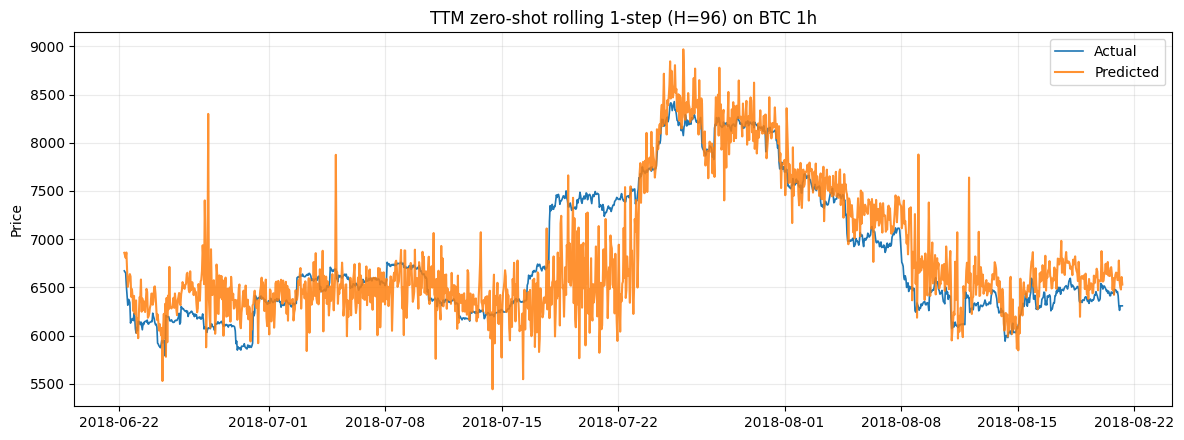

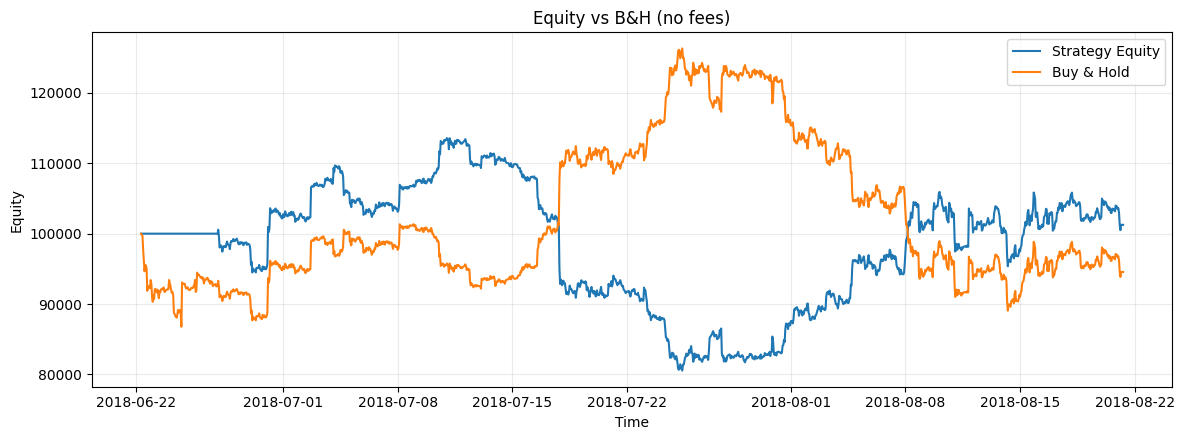

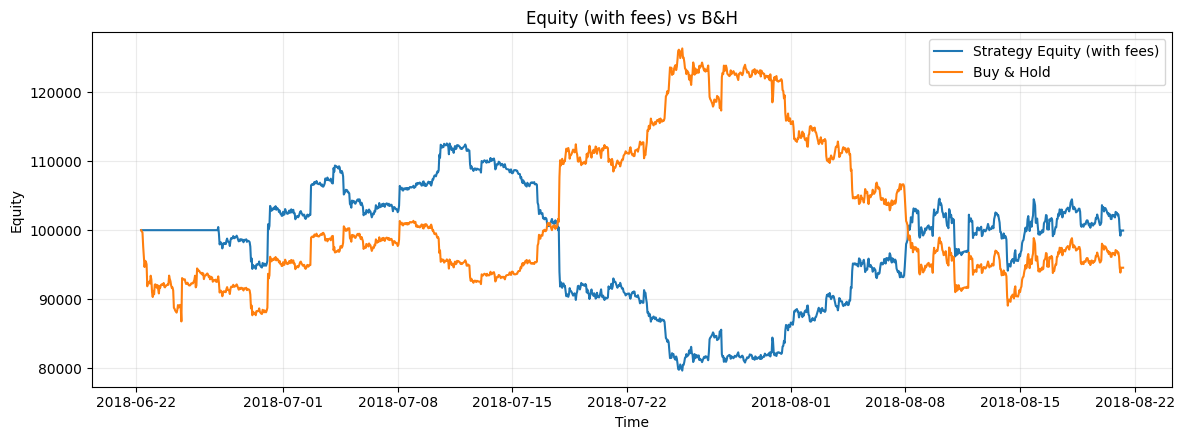

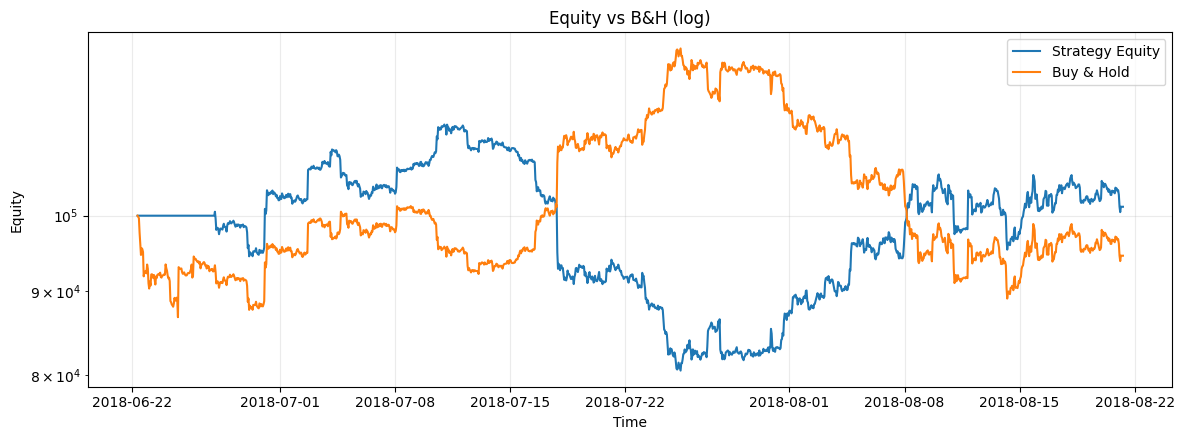

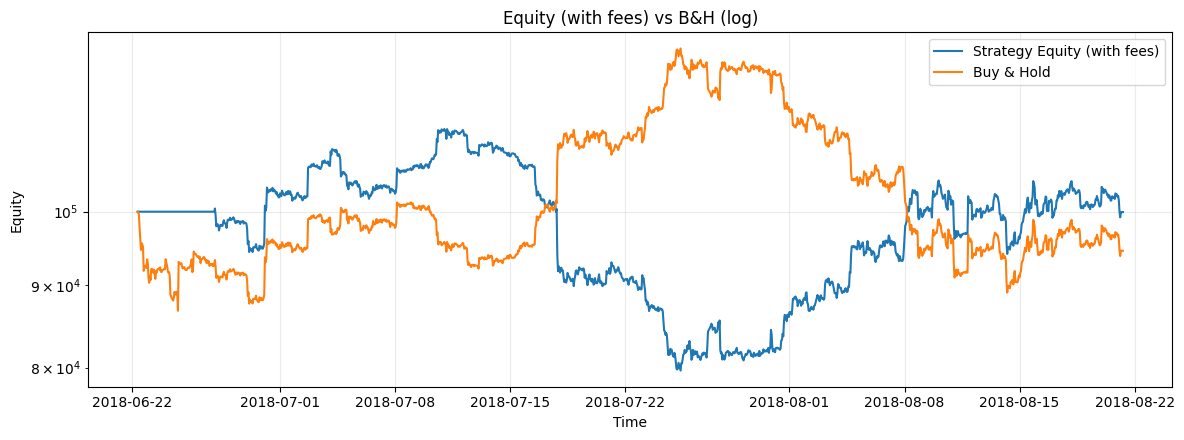

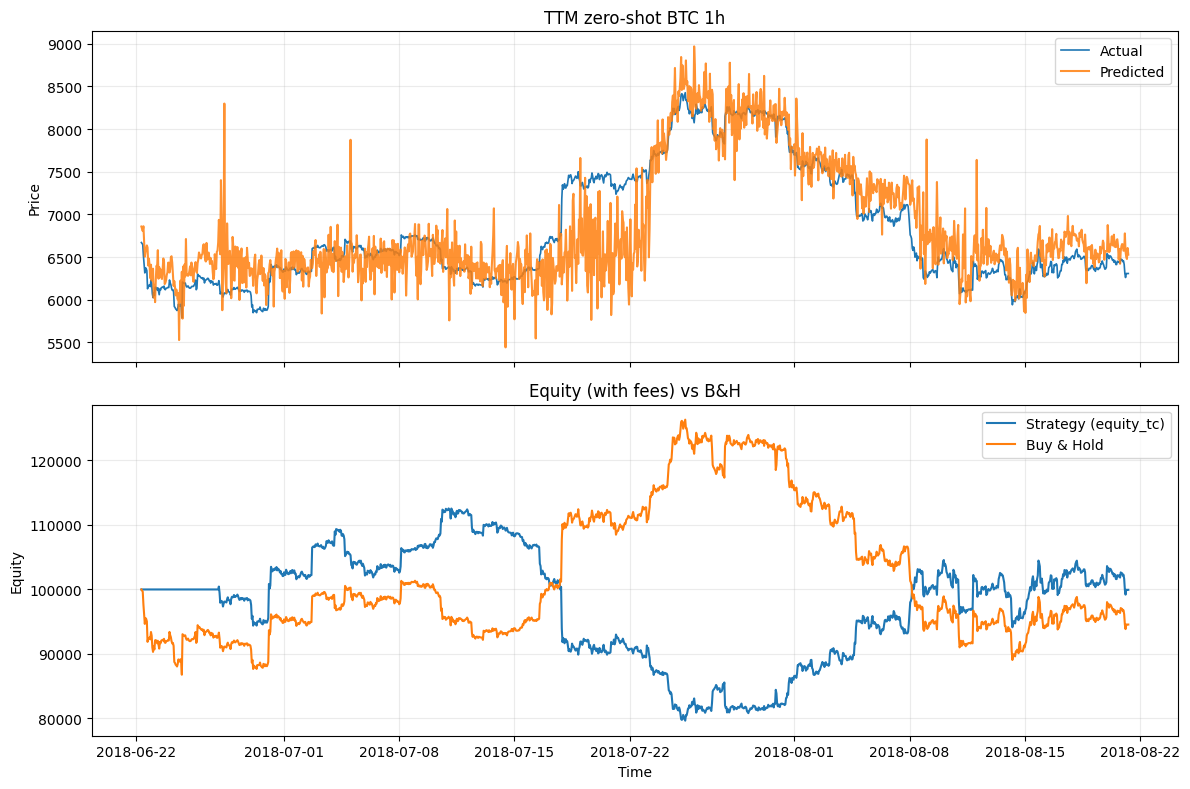

In [75]:
from utils.plotting import (
    plot_price_actual_vs_pred,
    plot_equity_no_tc_vs_bh,
    plot_equity_tc_vs_bh,
    plot_equity_no_tc_vs_bh_log,
    plot_equity_tc_vs_bh_log,
    plot_price_and_equity_panel,
)

# 1) Price: actual vs predicted
plot_price_actual_vs_pred(
    pred_df,
    title="TTM zero-shot rolling 1-step (H=96) on BTC 1h"
)

# 2) Equity vs Buy-and-Hold (no fees)
plot_equity_no_tc_vs_bh(
    pred_df,
    title="Equity vs B&H (no fees)"
)

# 3) Equity (with fees) vs Buy-and-Hold
plot_equity_tc_vs_bh(
    pred_df,
    title="Equity (with fees) vs B&H"
)

# 4) Log versions
plot_equity_no_tc_vs_bh_log(pred_df, title="Equity vs B&H (log)")
plot_equity_tc_vs_bh_log(pred_df, title="Equity (with fees) vs B&H (log)")

# 5) Two-panel combo
plot_price_and_equity_panel(
    pred_df,
    equity_col="equity_tc",  # or "equity"
    title_price="TTM zero-shot BTC 1h",
    title_equity="Equity (with fees) vs B&H",
    logy_equity=False,
)